In [78]:
from scipy.stats import mannwhitneyu, wilcoxon, ttest_ind, ttest_rel
import json
from statannot import add_stat_annotation
import seaborn as sns
import pandas as pd
from functools import reduce

In [79]:
def a12_unpaired(lst1, lst2):
    more = same = 0.0
    for x in lst1:
        for y in lst2:
            if x == y: same +=1
            elif x > y: more +=1
    return (more + 0.5*same)/(len(lst1)*len(lst2))


In [80]:

def interpret_effect_size(effect_size_score):
    if effect_size_score < 0.147:
        return "negligible"
    elif effect_size_score < 0.33:
        return "small"
    elif effect_size_score < 0.474:
        return "medium"
    else:
       return "large"

In [81]:
accuracies_file = "/workspaces/RAG_secure_code_generation/accuracies.csv"

In [82]:
accuracies = pd.read_csv(accuracies_file)

In [83]:
accuracies.head()

,model_temperature,use_rag,few_shot_examples,accuracy
0,gpt-4-0125-preview_0.5,True,3,0.765028
1,gpt-4-0125-preview_0.5,True,3,0.843667
2,gpt-4-0125-preview_0.5,True,3,0.493195
3,gpt-4-0125-preview_0.5,True,3,0.681285
4,gpt-4-0125-preview_0.5,True,3,0.982042


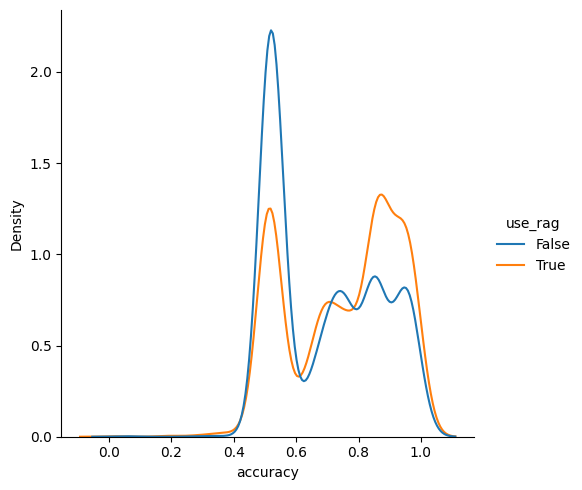

In [84]:
sns.displot(data = accuracies, x = "accuracy", hue = "use_rag", kind = "kde")

In [85]:
rag_accuracies = accuracies[accuracies["use_rag"] == True]["accuracy"].values.tolist()
no_rag_accuracies = accuracies[accuracies["use_rag"] == False]["accuracy"].values.tolist()

stat = mannwhitneyu(rag_accuracies, no_rag_accuracies)
pvalue = stat.pvalue

In [86]:
pvalue

4.483321625937445e-26

In [87]:
a12 = a12_unpaired(rag_accuracies, no_rag_accuracies)

effect_size_score = 2*abs(a12 -0.5)
effect_size = interpret_effect_size(effect_size_score)

effect_size_score, effect_size

(0.18281560564931865, 'small')

In [88]:
group_columns = ["model_temperature", "few_shot_examples"]
#group_columns = ["model_temperature"]

grouped_list = accuracies.groupby(group_columns+["use_rag"])["accuracy"].apply(list).reset_index()
grouped_avg = accuracies.groupby(group_columns+["use_rag"])["accuracy"].apply(lambda x: sum(x)/len(x)).reset_index()
#merge
grouped = grouped_avg.merge(grouped_list, on = group_columns+["use_rag"], suffixes=('_avg', '_list'))
grouped.head()

,model_temperature,few_shot_examples,use_rag,accuracy_avg,accuracy_list
0,anthropic-claude-3-opus_0.0,0,False,0.766700,"[0.5342155009451796, 0.7638941398865785, 0.493..."
1,anthropic-claude-3-opus_0.0,0,True,0.803452,"[0.9391304347826088, 0.9773156899810964, 0.939..."
2,anthropic-claude-3-opus_0.0,1,False,0.786568,"[0.8502835538752362, 0.8423440453686201, 0.842..."
3,anthropic-claude-3-opus_0.0,1,True,0.785531,"[0.5610586011342155, 0.7187145557655955, 0.853..."
4,anthropic-claude-3-opus_0.0,3,False,0.952910,"[0.9948960302457468, 0.940453686200378, 0.9810..."


In [89]:
rag_df = grouped[grouped["use_rag"] == True]
no_rag_df = grouped[grouped["use_rag"] == False]
#drop use rag columns
rag_df = rag_df.drop(columns = ["use_rag"])
no_rag_df = no_rag_df.drop(columns = ["use_rag"])
rq1 = pd.merge(rag_df, no_rag_df, on = group_columns, suffixes=('_rag', '_no_rag'))
rq1.head()


,model_temperature,few_shot_examples,accuracy_avg_rag,accuracy_list_rag,accuracy_avg_no_rag,accuracy_list_no_rag
0,anthropic-claude-3-opus_0.0,0,0.803452,"[0.9391304347826088, 0.9773156899810964, 0.939...",0.766700,"[0.5342155009451796, 0.7638941398865785, 0.493..."
1,anthropic-claude-3-opus_0.0,1,0.785531,"[0.5610586011342155, 0.7187145557655955, 0.853...",0.786568,"[0.8502835538752362, 0.8423440453686201, 0.842..."
2,anthropic-claude-3-opus_0.0,3,0.896694,"[0.7175803402646502, 0.940453686200378, 0.9234...",0.952910,"[0.9948960302457468, 0.940453686200378, 0.9810..."
3,anthropic-claude-3-opus_0.0,5,0.926399,"[0.9396975425330812, 0.9396975425330812, 0.939...",0.872695,"[0.940453686200378, 0.940453686200378, 0.76294..."
4,anthropic-claude-3-opus_0.5,0,0.751097,"[0.8497164461247637, 0.7638941398865785, 0.520...",0.723466,"[0.7623818525519849, 0.531758034026465, 0.5340..."


In [90]:
rq1["improved"] = rq1["accuracy_avg_rag"] > rq1["accuracy_avg_no_rag"]
rq1 = rq1.drop(columns = ["accuracy_avg_rag", "accuracy_avg_no_rag"])
rq1.head()

,model_temperature,few_shot_examples,accuracy_list_rag,accuracy_list_no_rag,improved
0,anthropic-claude-3-opus_0.0,0,"[0.9391304347826088, 0.9773156899810964, 0.939...","[0.5342155009451796, 0.7638941398865785, 0.493...",True
1,anthropic-claude-3-opus_0.0,1,"[0.5610586011342155, 0.7187145557655955, 0.853...","[0.8502835538752362, 0.8423440453686201, 0.842...",False
2,anthropic-claude-3-opus_0.0,3,"[0.7175803402646502, 0.940453686200378, 0.9234...","[0.9948960302457468, 0.940453686200378, 0.9810...",False
3,anthropic-claude-3-opus_0.0,5,"[0.9396975425330812, 0.9396975425330812, 0.939...","[0.940453686200378, 0.940453686200378, 0.76294...",True
4,anthropic-claude-3-opus_0.5,0,"[0.8497164461247637, 0.7638941398865785, 0.520...","[0.7623818525519849, 0.531758034026465, 0.5340...",True


In [91]:
rq1["pvalue"] = rq1.apply(lambda row: mannwhitneyu(row["accuracy_list_no_rag"], row["accuracy_list_rag"]).pvalue, axis = 1)
rq1["statistical_significant"] = rq1["pvalue"] < 0.05
rq1.head()

,model_temperature,few_shot_examples,accuracy_list_rag,accuracy_list_no_rag,improved,pvalue,statistical_significant
0,anthropic-claude-3-opus_0.0,0,"[0.9391304347826088, 0.9773156899810964, 0.939...","[0.5342155009451796, 0.7638941398865785, 0.493...",True,0.103025,False
1,anthropic-claude-3-opus_0.0,1,"[0.5610586011342155, 0.7187145557655955, 0.853...","[0.8502835538752362, 0.8423440453686201, 0.842...",False,0.819926,False
2,anthropic-claude-3-opus_0.0,3,"[0.7175803402646502, 0.940453686200378, 0.9234...","[0.9948960302457468, 0.940453686200378, 0.9810...",False,0.007847,True
3,anthropic-claude-3-opus_0.0,5,"[0.9396975425330812, 0.9396975425330812, 0.939...","[0.940453686200378, 0.940453686200378, 0.76294...",True,0.323464,False
4,anthropic-claude-3-opus_0.5,0,"[0.8497164461247637, 0.7638941398865785, 0.520...","[0.7623818525519849, 0.531758034026465, 0.5340...",True,0.517528,False


In [92]:
rq1["a12"] = rq1.apply(lambda row: a12_unpaired(row["accuracy_list_rag"], row["accuracy_list_no_rag"]), axis = 1)
rq1["effect_size"] = rq1["a12"].apply(lambda x: interpret_effect_size(2*abs(x -0.5)))
rq1.drop(columns = ["accuracy_list_rag", "accuracy_list_no_rag"], inplace = True)
rq1.head()

,model_temperature,few_shot_examples,improved,pvalue,statistical_significant,a12,effect_size
0,anthropic-claude-3-opus_0.0,0,True,0.103025,False,0.608726,small
1,anthropic-claude-3-opus_0.0,1,False,0.819926,False,0.515705,negligible
2,anthropic-claude-3-opus_0.0,3,False,0.007847,True,0.324671,medium
3,anthropic-claude-3-opus_0.0,5,True,0.323464,False,0.569570,negligible
4,anthropic-claude-3-opus_0.5,0,True,0.517528,False,0.545455,negligible


In [93]:
len(rq1)

68

In [94]:
#improvemenets
len(rq1[rq1["improved"] == True])

52

In [95]:
#statistcally significant improvements
len(rq1[(rq1["improved"] == True) & (rq1["statistical_significant"] == True)])

24

In [96]:
#effect size of statistically significant improvements
rq1[(rq1["improved"] == True) & (rq1["statistical_significant"] == True)]["effect_size"].value_counts()

effect_size
medium    11
large      7
small      6
Name: count, dtype: int64